In [295]:
# %load utilities
import utilities

In [296]:
#Import Dataset

df = pd.read_csv('loan_default_prediction.csv')
print(df.shape)

(87500, 30)


In [297]:
#drop
vdrop=['ID','Validation','Designation','Debt_to_Income','Postal_Code','Deprecatory_Records',\
            'Inquiries','Gross_Collection','Sub_GGGrade','Total_Unpaid_CL','File_Status','Claim_Type','Due_Fee']
df=df.drop(vdrop,axis=1)
df.shape

(87500, 17)

In [298]:
#Conversão dos anos de experiência para numérico
df['Experience']=df['Experience'].apply(lambda i: 10 if i[0:1]=='>' else 1 if i[0:1]=='<' else int(i[0:1]))
#Conversão da duração para numérico
df['Duration']=df['Duration'].apply(lambda i : i.replace(' years','years')).astype(str)
#Conversão da GGGrade valor ordinal para numérico
df['GGGrade']=df['GGGrade'].apply(romanToInt).astype(int)
#criacao de debt to income
#calcular o total da divida e o rendimento anual. uma espécie de "taxa de esforço"
df['debt_to_income']=df['Unpaid_Amount']/df['Yearly_Income']
#ver resultado
#df.head()

In [299]:
#eliminar observações com pelo menos uma feature sem valores
df=df.dropna()
#drop duplicates
df.drop_duplicates()
df.shape

(77376, 18)

In [300]:
#df.describe()
df.head(5)

,Asst_Reg,GGGrade,Experience,Yearly_Income,Home_Status,Unpaid_2_years,Already_Defaulted,Lend_Amount,Interest_Charged,Usage_Rate,Present_Balance,State,Account_Open,Duration,Unpaid_Amount,Reason,Default,debt_to_income
0,421802,2,10,633600.00,MORTGAGE,0,0,42023.25,15.39,88.924,607161.90,California,17,3years,31216.05,debt consolidation,0,0.049268
1,3964312,4,7,85483.20,RENT,0,0,38133.00,9.94,102.856,269234.06,NC,15,5years,11660.49,debt consolidation,0,0.136407
2,4247560,3,1,79200.00,RENT,0,0,17100.00,22.35,60.372,22476.53,Florida,7,5years,5637.87,major purchase,0,0.071185
3,197179,3,1,61600.00,RENT,0,0,5130.00,10.36,116.272,15242.09,NewJersey,9,3years,15607.17,major purchase,1,0.253363
4,4646684,5,2,68053.92,RENT,0,0,19665.00,13.68,127.280,65433.94,LA,10,5years,27472.86,debt consolidation,0,0.403693


In [301]:
v_num_cont=['Asst_Reg','Experience','Yearly_Income','Lend_Amount','Interest_Charged','Usage_Rate',
            'Present_Balance','Unpaid_Amount','debt_to_income']
v_num_disc=['Unpaid_2_years','Already_Defaulted','Account_Open']
v_cat_ord=['Home_Status','State','Reason','Duration']#,'GGGrade']

In [303]:
from scipy import stats
display(df.shape)
#remover observações com home status 'none' e 'other'
df=df[(df['Home_Status']!='OTHER')&(df['Home_Status']!='NONE')]
#remover linhas com outliers, definidos como mais que 3 desvios-padrão acima/abaixo da média
df=df[(np.abs(stats.zscore(df[v_num_cont])) < 3).all(axis=1)]
df.shape


(77376, 18)

(74542, 18)

# Undersampling

In [281]:
#ver quantas observações têm default=1
display((df['Default']==1).sum())
#sample de 5000 obs com default =1
defaulted = df[df['Default']==1].sample(n=5000, random_state=101)
#sample de 5000 obs com default =0
notdefault = df[df['Default']==0].sample(n=5000, random_state=101)
#agregar as observações
df = pd.concat([defaulted,notdefault],axis=0)
#sort aleatório das obs
df = df.sample(frac=1).reset_index(drop=True)
df.shape

14184

(10000, 18)

In [282]:
df[v_num_disc].describe()

,Unpaid_2_years,Already_Defaulted,Account_Open
count,10000.000000,10000.000000,10000.000000
mean,0.315900,0.005300,12.526900
std,0.855792,0.076632,5.129104
min,0.000000,0.000000,2.000000
25%,0.000000,0.000000,9.000000
50%,0.000000,0.000000,12.000000
75%,0.000000,0.000000,15.000000
max,16.000000,2.000000,51.000000


# Train vs test sample: standard and cross-validation

In [284]:
# Split the data into features (X) and labels (y)
#QUANDO PIPELINE ESTIVER PARA TODAS AS VARIÁVEIS, MUDAR O X
X = df[v_num_cont+v_num_disc+v_cat_ord]
y = df['Default']

# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#script não ativado para fazer cross validation manual (normalmente o scikit learn faz tudo automático)
from sklearn.model_selection import KFold
#kfold = KFold(n_splits=5,shuffle=True)
#for train_index, test_index in kfold.split(X):
#    print("Train index:", train_index, "Test index:", test_index)
#    X_train, X_test = X.loc[train_index], X.loc[test_index]
#    y_train, y_test = y.loc[train_index], y.loc[test_index]

# Pipelines

In [285]:
#1a parte: tentar reduzir assimetria das variáveis

#está suficientemente distante de 0 para ter certeza que é assimétrica
#como se vê isso? quanto mais pequeno for o p-value (2a linha dataframe), mais certezas temos que é assimétrica

#verificar assimetria das features numéricas
dskew=skew_df(X_train[v_num_cont+v_num_disc])
#mostrar output
display(dskew)
#ver lista de features assimétricas, pvalue < 5%
v_skew=list(dskew.columns[dskew.loc['p_value']<0.05])
#lista de simétricas são as restantes
v_sym=list(set(X_train[v_num_cont+v_num_disc].columns) - set(v_skew))
#check
v_skew

,Asst_Reg,Experience,Yearly_Income,Lend_Amount,Interest_Charged,Usage_Rate,Present_Balance,Unpaid_Amount,debt_to_income,Unpaid_2_years,Already_Defaulted,Account_Open
skewness,13.71,-5.85,37.7,22.68,-0.37,-5.69,34.89,42.13,33.52,76.0,109.69,35.96
p_value,0.00,0.00,0.0,0.00,0.71,0.00,0.00,0.00,0.00,0.0,0.00,0.00


['Asst_Reg',
 'Experience',
 'Yearly_Income',
 'Lend_Amount',
 'Usage_Rate',
 'Present_Balance',
 'Unpaid_Amount',
 'debt_to_income',
 'Unpaid_2_years',
 'Already_Defaulted',
 'Account_Open']

In [304]:
cc=[]
for i in v_cat_ord:
    c=df[i].value_counts()/df.shape[0]
    #list(c[c>.05].index)
    print('Features com predominância em mais de 5% das observações:'+str(list(c[c>=.05].index)))
    print('Features com predominância em menos de 5% das observações:'+str(list(c[c<.05].index)))
    #cc=cc+c
    
cc

Features com predominância em mais de 5% das observações:['MORTGAGE', 'RENT', 'OWN']
Features com predominância em menos de 5% das observações:[]
Features com predominância em mais de 5% das observações:['California', 'TX', 'Newyork', 'Florida']
Features com predominância em menos de 5% das observações:['IL', 'NewJersey', 'PA', 'Ohio', 'GA', 'NC', 'VA', 'MI', 'Maryland', 'AZ', 'MA', 'CO', 'WA', 'MN', 'IN', 'MO', 'TN', 'CT', 'NV', 'AL', 'WI', 'OR', 'LA', 'SC', 'KY', 'KS', 'OK', 'AR', 'UT', 'NM', 'HI', 'MS', 'NH', 'WV', 'RI', 'MT', 'DE', 'DC', 'AK', 'WY', 'SD', 'VT', 'NE', 'ND', 'ME']
Features com predominância em mais de 5% das observações:['debt  consolidation', 'credit  card', 'home  improvement']
Features com predominância em menos de 5% das observações:['other', 'major  purchase', 'medical', 'small  business', 'car', 'moving', 'vacation', 'house', 'wedding', 'RENTwable  energy']
Features com predominância em mais de 5% das observações:['3years', '5years']
Features com predominância 

[]

In [305]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# Define the transformations to apply to the column
transformer = ColumnTransformer([
    ('yeoj', PowerTransformer(), v_skew), #aplico transformação que corrige assimetria às assimétricas
    ('std', StandardScaler(), v_sym),     #aplico transformação às simétricas (sub média e dividir desvio padrao)
    ('oneh', OneHotEncoder(min_frequency=0.05,handle_unknown='ignore',#drop='if_biNameErrorary',
                           sparse_output=False), v_cat_ord)
])

#pipeline= Pipeline([
    #('ct', transformer),
    #('to_df', pd.DataFrame, {'columns': v_skew+v_sym})
    #("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = (v_skew + v_sym))))
#])

# Transform the data
pfit = transformer.fit(X_train)

categories= pfit.transformers_[2][1].categories_
categories_out=pfit.transformers_[2][1].infrequent_categories_

v_onehot_drop=list(np.concatenate([np.concatenate([categories[i][np.isin(categories[i], categories_out[i], invert=True)]],axis=0) 
                        for i in range(0,len(categories))],axis=0))


v_onehot=list(np.concatenate([(np.concatenate((np.array(j),
                       (np.array(['Other_Cat'+str(k)]) if categories_out[k] is not None else np.array([]))),axis=0)) 
                         for k,j in enumerate(
                         [np.concatenate([categories[i][np.isin(categories[i], categories_out[i], invert=True)]],axis=0) 
                        for i in range(0,len(categories))]
                         )]))

#X_train_transf = transformer.transform(X_train)
X_train_transf = pd.DataFrame(pfit.transform(X_train),columns = (v_skew + v_sym+v_onehot)
                              ,index=X_train.index)

#aplicar transformações ao teste calcula
#X_test_transf = transformer.transform(X_test)
X_test_transf = pd.DataFrame(pfit.transform(X_test),columns = (v_skew + v_sym+v_onehot)
                            ,index=X_test.index)

display(round(X_train_transf.describe(),2))
#vamos dar um check se o dataframe ficou "menos assimétrico"
skew_df(X_train_transf[v_skew+v_sym])

,Asst_Reg,Experience,Yearly_Income,Lend_Amount,Usage_Rate,Present_Balance,Unpaid_Amount,debt_to_income,Unpaid_2_years,Already_Defaulted,...,Florida,Newyork,TX,Other_Cat1,credit card,debt consolidation,home improvement,Other_Cat2,3years,5years
count,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,...,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00
mean,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,...,0.06,0.08,0.08,0.62,0.24,0.60,0.05,0.11,0.73,0.27
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,0.25,0.27,0.27,0.49,0.43,0.49,0.22,0.31,0.45,0.45
min,-2.26,-1.52,-3.86,-2.62,-2.37,-3.96,-3.40,-2.09,-0.49,-0.07,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,-0.87,-0.84,-0.68,-0.74,-0.71,-0.80,-0.67,-0.77,-0.49,-0.07,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.04,0.01,-0.02,0.05,-0.06,-0.03,-0.01,-0.49,-0.07,...,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00
75%,0.91,1.09,0.70,0.75,0.76,0.85,0.68,0.74,-0.49,-0.07,...,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,1.00
max,1.48,1.09,2.88,1.97,2.87,2.08,3.25,2.44,2.09,14.29,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


,Asst_Reg,Experience,Yearly_Income,Lend_Amount,Usage_Rate,Present_Balance,Unpaid_Amount,debt_to_income,Unpaid_2_years,Already_Defaulted,Account_Open,Interest_Charged
skewness,-5.91,-9.03,-0.0,-1.73,-6.96,-2.18,0.74,2.82,41.89,106.08,-0.0,-0.37
p_value,0.00,0.00,1.0,0.08,0.00,0.03,0.46,0.00,0.00,0.00,1.0,0.71


# Simple Classificator verified

In [339]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix,roc_auc_score, roc_curve
#Não usar bernoulli porque faz mais sentido para variaveis binarias
#from sklearn.naive_bayes import BernoulliNB
#from seaborn as sns

rnd_clf=RandomForestClassifier(n_estimators=100)
log_clf=LogisticRegression()
svm_clf=SVC()
dtc_clf=DecisionTreeClassifier()
knn_clf=KNeighborsClassifier()
mpl_clf=MLPClassifier()
gnb_clf=GaussianNB()
#Adicionar o resto dos modelos superviselearning menos o xgboost
#bnb_clf=BernoulliNB()


voting_clf=VotingClassifier(
    estimators=[('lr',log_clf),('rf',rnd_clf),('svm',svm_clf)
                ,('dtc',dtc_clf),('knn',knn_clf),('mpl',mpl_clf),('gnb',gnb_clf)],
    voting='hard'
)
 
dataMetrics = pd.DataFrame(columns=['Accuracy','Precision','Recall','F1'])
for clf in (log_clf,rnd_clf,svm_clf,dtc_clf,knn_clf,mpl_clf,gnb_clf,voting_clf):
    clf.fit(X_train_transf,y_train)
    y_pred=clf.predict(X_test_transf)   
    #DataFrame
    dataMetrics.loc[clf.__class__.__name__, ['Accuracy']] = metrics.accuracy_score(y_test, y_pred).round(2)
    dataMetrics.loc[clf.__class__.__name__, ['Precision']] = metrics.precision_score(y_test, y_pred).round(2)
    dataMetrics.loc[clf.__class__.__name__, ['Recall']] = metrics.recall_score(y_test, y_pred).round(2)
    dataMetrics.loc[clf.__class__.__name__, ['F1']] = metrics.f1_score(y_test, y_pred).round(2)
    #Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    #sns.heatmap(cf_matrix)
    #Generate the ROC AUC Curve
    roc_auc = roc_auc_score(y_test, y_pred)
    #ROC AUC Curve
    fpr, tpr, thresholds = roc_curve(y_test,y_pred)
    
dataMetrics
    
#experimentar pesos, fazer grid search

#APLICAR TRAIN TEST UMAS 30 VEZES 

,Accuracy,Precision,Recall,F1
LogisticRegression,0.73,0.74,0.72,0.73
RandomForestClassifier,0.71,0.71,0.74,0.72
SVC,0.73,0.72,0.77,0.74
DecisionTreeClassifier,0.65,0.67,0.64,0.65
KNeighborsClassifier,0.68,0.69,0.69,0.69
MLPClassifier,0.71,0.73,0.69,0.71
GaussianNB,0.7,0.69,0.76,0.72
VotingClassifier,0.73,0.72,0.76,0.74


In [309]:
#Adicionar cscript dos classificador com hiperparametros

# Feature selection/Unsupervise Learning

## PCA

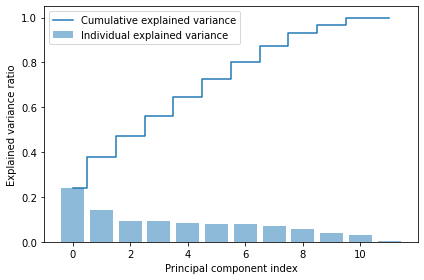

In [310]:
#Apply PCA to the training data to reduce the dimensionality
#ALWAYS STANDARDIZE
#VER SE VALE A PENA FAZER UNS GRAFICOS
#POR EXEMPLO
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=0.9999)

X_pca=pca.fit(X_train_transf[v_skew+v_sym])
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [311]:
pca = PCA(n_components=0.80)

X_pca=pca.fit(X_train_transf[v_skew+v_sym])

X_train_pca=pd.DataFrame(pca.transform(X_train_transf[v_skew+v_sym]),
                         columns=['pca_v'+str(i+1) for i in range (0,X_pca.n_components_)],
                        index=X_train_transf.index)

X_test_pca=pd.DataFrame(pca.transform(X_test_transf[v_skew+v_sym]),
                         columns=['pca_v'+str(i+1) for i in range (0,X_pca.n_components_)],
                        index=X_test_transf.index)

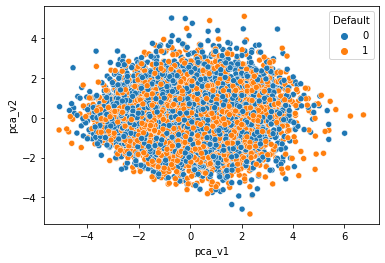

In [312]:
import seaborn as sns

df_pca=pd.concat([X_train_pca,pd.DataFrame(y_train)],axis=1)
#display(df_pca.head(5))

sns.scatterplot(x='pca_v1', y='pca_v2', hue='Default', data=df_pca);



,pca_v1,pca_v2,pca_v3,pca_v4,pca_v5,pca_v6,pca_v7,Default
Default,0.04,-0.03,-0.03,-0.31,0.08,0.4,-0.09,1.0


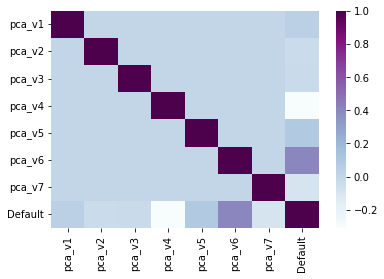

In [313]:
corr = df_pca.corr()
display(round(corr.iloc[[-1],:],2))

# Plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,cmap="BuPu");

In [314]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

# Use cross-validation to evaluate logistic regression with different numbers of principal components
pca = PCA()
logreg = LogisticRegression()

n_components = range(1, X_train_transf[v_skew+v_sym].shape[1]+1)
scores = []

for n in n_components:
    pca.n_components = n
    X_train_pca = pca.fit_transform(X_train_transf[v_skew+v_sym])
    score = np.mean(cross_val_score(logreg, X_train_pca, y_train, cv=5, scoring='f1'))
    scores.append(score)

# Select the number of components that gives the highest cross-validation score
optimal_n_components = n_components[np.argmax(scores)]
display(scores)

# Train logistic regression model on full training set with optimal number of components
pca.n_components = optimal_n_components
display(optimal_n_components)

[0.4944207992503452,
 0.5053030493616781,
 0.520112888397968,
 0.6502956001274929,
 0.6538715629281392,
 0.7280966614056545,
 0.7327394266092175,
 0.7344599766533204,
 0.7327358264934918,
 0.732549632622163,
 0.7324568540861358,
 0.7313741823750545]

8

## Kmeans, LogisticRegression

In [315]:
sse=[]
silhscores = []
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
k_rng=range(1,15)
for k in k_rng:
    km=KMeans(n_clusters=k,n_init=10)
    km.fit(X_train_transf)
    sse.append(km.inertia_)
    if k>1:
        km_pred=km.predict(X_train_transf)
        silhscore = silhouette_score(X_train_transf, km_pred)
        silhscores.append(silhscore)
display(silhscores)    
sse

#--Lento

[0.13147545877957834,
 0.09950626156093878,
 0.10553367277028725,
 0.10911611792558147,
 0.0932841823613658,
 0.0864636347649492,
 0.08813736765402641,
 0.08386838698747721,
 0.07997486018449373,
 0.07741037226160799,
 0.07610972780750758,
 0.07934497327174324,
 0.07591910506215806]

[112900.84500000002,
 97257.50132196308,
 91210.11528537309,
 83130.13488303337,
 78402.60110825096,
 75213.55628091097,
 73102.0551572311,
 71208.9789958001,
 69494.26626422467,
 68023.07349305534,
 66837.88592908267,
 65690.41392247572,
 64783.51588271568,
 63828.39925631264]

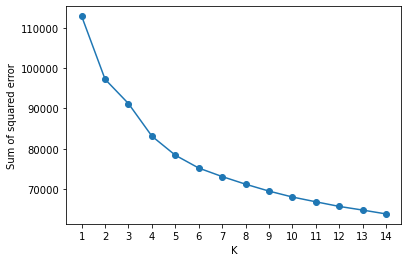

In [316]:
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.xticks(k_rng)
plt.plot(k_rng,sse, '-o');

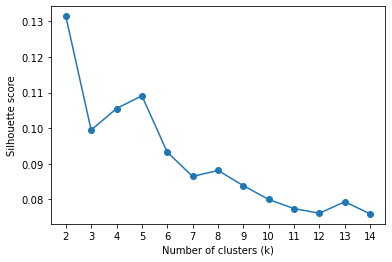

In [317]:
# Plot the silhouette scores
plt.plot(range(2, 15), silhscores, '-o')
plt.xticks(range(2, 15))
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.show()

In [318]:
#clusters identified by silhouette
k=range(2,15)[np.array(silhscores).argmax()]

km=KMeans(n_clusters=k,n_init=10)
km_fit=km.fit(X_train_transf)

In [320]:
#Centros dos clusters
cluster=km_fit.predict(X_train_transf)
unique, counts = np.unique(cluster, return_counts=True)
print(np.asarray((unique, counts)).T)

km_fit.cluster_centers_

[[   0 4064]
 [   1 3936]]


array([[ 0.01406714,  0.21140996,  0.4679858 ,  0.54956876,  0.30864576,
         0.54130732,  0.70207855,  0.47559228,  0.03508417,  0.01124261,
         0.36793447,  0.01182613,  0.66715867,  0.08118081,  0.25166052,
         0.1397294 ,  0.05313653,  0.07429274,  0.09175892,  0.64108241,
         0.26838868,  0.62361624,  0.04895449,  0.05904059,  0.61549815,
         0.38450185],
       [-0.01453188, -0.21839427, -0.48344657, -0.56772478, -0.31884244,
        -0.55919041, -0.72527301, -0.49130435, -0.03624324, -0.01161403,
        -0.38008986, -0.01221683,  0.32452351,  0.09987294,  0.57560356,
         0.17102922,  0.0772554 ,  0.08310038,  0.07166455,  0.59695044,
         0.20533672,  0.58373571,  0.05209657,  0.158831  ,  0.8386277 ,
         0.1613723 ]])

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

class KMeans_label(KMeans):
    def fit_transform(self, X, y=None):
        return self.fit_predict(X)

pipeline = Pipeline([
    ('cluster', KMeans_label(n_init=10,n_clusters=3)),
    ('binarize', OneHotEncoder())
])

kk=pipeline[:-1].fit_transform(X_train_transf)
#kk.labels_



In [323]:
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# Create a pipeline with KMeans and OneHotEncoder
pipeline = Pipeline([
    ('kmeans', KMeans(n_init=10,n_clusters=3)),  # leave the number of clusters unspecified
    ('onehot', OneHotEncoder(sparse_output=False)),
    ('lr', LogisticRegression())
])


kp=pipeline.fit(X_train_transf, y_train)

In [324]:
#kp.named_steps["onehot"] 
kp[:-2].fit_transform(X_train_transf)

array([[3.22838398, 3.81044843, 5.37267662],
       [3.56650682, 3.49753279, 2.97120804],
       [4.84016955, 4.77941538, 3.38911625],
       ...,
       [4.05456876, 3.90207946, 3.41525369],
       [3.0789463 , 2.81447719, 3.5674962 ],
       [4.11030243, 3.77542835, 2.95313523]])

In [325]:
# Create a grid search with cross-validation to find the best number of clusters
param_grid = {'kmeans__n_clusters': range(2, 15)}  # specify the range of cluster numbers to try
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_transf, y_train)

# Print the best number of clusters and the best f1 score
print(f"Best number of clusters: {grid_search.best_params_['kmeans__n_clusters']}")
print(f"Best f1 score: {grid_search.best_score_:.2f}")

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\familia feliz\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\familia feliz\AppData\Local\Temp\ipykernel_27908\1156858439.py", line 4, in <cell line: 4>
    grid_search.fit(X_train_transf, y_train)
  File "C:\Users\familia feliz\anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 875, in fit
    self._run_search(evaluate_candidates)
  File "C:\Users\familia feliz\anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 1389, in _run_search
  File "C:\Users\familia feliz\anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 822, in evaluate_candidates
    out = parallel(
  File "C:\Users\familia feliz\anaconda3\lib\site-packages\joblib\parallel.py", line 1088, in __call__
  File "C:\Users\familia feliz\anaconda3\lib\site-packages\joblib\parallel.py", line 901, in dispatch_one_batch


In [ ]:
display(grid_search.best_params_)
display(grid_search.best_score_)

#display(grid_search.score(X_train, y_train))

In [ ]:
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV, KFold


########################################
# Set up the cross-validation and grid search
kfold = KFold(n_splits=5)
param_grid = {'n_clusters': [2, 3, 4, 5, 6]}
model = KMeans()
grid_search = GridSearchCV(model, param_grid, cv=kfold, return_train_score=True)

# Run the grid search
grid_search.fit(X, y)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Re-train the model on the entire dataset with the best parameters
model = KMeans(**grid_search.best_params_)
X_clusters = model.fit_predict(X)

# Models

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the logistic regression model
model = LogisticRegression()
# Define the parameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Create the GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')

# Fit the model to the data
grid_search.fit(X_train_transf, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.2f}")

# Make predictions on new data
y_pred = grid_search.predict(X_test_transf)

## SVM

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

# Define the logistic regression model
model = LinearSVC(loss='hinge',max_iter=10000)
# Define the parameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Create the GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')

# Fit the model to the data
grid_search.fit(X_train_transf, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.2f}")

# Make predictions on new data
y_pred = grid_search.predict(X_test_transf)

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
# Create the parameter grid
param_grid = {
    'max_depth': [2,3 ,5, 10, 15, 20],
    'min_samples_leaf': [2, 4, 6, 8],
    'min_samples_split': [2, 4, 6, 8],
    'criterion': ['gini', 'entropy']
}

tree_clf=DecisionTreeClassifier()

# Create the grid search object
grid_search = GridSearchCV(estimator=tree_clf, param_grid=param_grid, cv=5,scoring='f1')

# Fit the grid search to the training data
tree_clf_cv=grid_search.fit(X_train_transf, y_train)

In [ ]:
# Print the best parameters
display(tree_clf_cv.best_score_)
print(tree_clf_cv.best_params_)
best_tree_params=tree_clf_cv.best_params_
best_tree=DecisionTreeClassifier(**best_tree_params)
best_tree

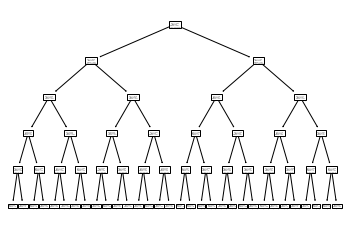

In [41]:
from sklearn.tree import plot_tree
plot_tree(best_tree.fit(X_train_transf, y_train));

In [ ]:
import graphviz
from sklearn.tree import export_graphviz

dot_data=export_graphviz(best_tree,feature_names=X_train_transf.columns,
                         class_names=['no default','default'],
                         filled=True)

graph=graphviz.Source(dot_data)
graph

## Naive Bayes

In [ ]:
#não precisamos de adicionar hiperparametro devido ao facto de já termos a variancia normalizada das features
#no limite, hiperparametros só no pré processamento, ajustadando no no de bins 
from sklearn.preprocessing import KBinsDiscretizer
est=KBinsDiscretizer(n_bins=5,encode='ordinal',strategy='quantile')
est.fit(X_train_tranf)
Xt_train=est.transform(X_train_transf)
Xt_test=est.transform(X_test)

from sklearn.naive_bayes import MultinomialNB
mnNB=MultinomialNB()
mnNB.fit(Xt_train,y_train)
y_pred=mnNB.predict(Xt_test)

In [69]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# Create the pipeline
pipeline = Pipeline([
    ('discretizer', KBinsDiscretizer(encode='ordinal',strategy='quantile')),
    ('classifier', MultinomialNB())
])

# Create the parameter grid
param_grid = {
    'discretizer__n_bins': [3, 5, 7, 9]
}

# Create the grid search object
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)

# Fit the grid search to the training data
grid_search.fit(X_train_transf, y_train)

# Print the best parameters
print(grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

display(grid_search.best_estimator_)

# Evaluate the best model on the test data
accuracy = best_model.score(X_test_transf, y_test)
print('Test accuracy:', accuracy)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'discretizer__n_bins': 7}


Pipeline(steps=[('discretizer', KBinsDiscretizer(encode='ordinal', n_bins=7)),
                ('classifier', MultinomialNB())])

Test accuracy: 0.6805


In [ ]:
from sklearn.naive_bayes import GaussianNB
gNB=MultinomialNB()
gNB.fit(X_train_transf,y_train)
y_pred=gNB.predict(X_test)

## Random Forest

In [63]:
from sklearn.ensemble import RandomForestClassifier
#rf_clf=RandomForestClassifier()
#rf_clf.fit(X_train_transf,y_train)
#y_pred=rf_Model.predict(X_test_transf)

param_grid={'n_estimators':[int(x) for x in np.linspace(10,100,4)],
            'max_features':['auto','sqrt'],
            'max_depth': [2, 3 ,5, 10],
            'min_samples_leaf': [4, 6, 8],
            'min_samples_split': [6, 8],
            'bootstrap':[True,False]
}

rf_clf=RandomForestClassifier()

# Create the grid search object
rf_clf_gs = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5,scoring='f1',n_jobs=-1)

# Fit the grid search to the training data
rf_clf_cv=rf_clf_gs.fit(X_train_transf, y_train)

In [64]:
# Print the best parameters
display(rf_clf_cv.best_score_)
best_rf_params=rf_clf_cv.best_params_
display(best_rf_params)
best_rf=RandomForestClassifier(**best_rf_params)
best_rf

0.7488484026677504

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 6,
 'min_samples_split': 8,
 'n_estimators': 100}

RandomForestClassifier(max_depth=10, max_features='auto', min_samples_leaf=6,
                       min_samples_split=8)

In [ ]:
from sklearn.model_selection import GridSearchCV
rf_Grid=GridSearchCV(rf_Model,param_grid,cv=5)
rf_Grid.fit(X_train_transf,y_train)

In [ ]:

y_pred=rf_Grid.predict(X_test)
rf_Grid.best_score_

## Kneighbors

In [46]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_train_transf, y_train)


KNeighborsClassifier(n_neighbors=3)

In [57]:
from sklearn.neighbors import KNeighborsClassifier

# Create the parameter grid
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
    'leaf_size': [10, 30, 50, 70]
}

# Create the k-NN classifier
knn = KNeighborsClassifier()

# Create the grid search object
knn_gs = GridSearchCV(estimator=knn, param_grid=knn_param_grid, cv=5,scoring='f1',n_jobs=-1)


# Fit the grid search to the training data
knn_clf_cv=knn_gs.fit(X_train_transf, y_train)

In [61]:
# Print the best parameters
display(knn_clf_cv.best_score_)
best_knn_params=knn_clf_cv.best_params_
display(best_knn_params)
best_knn=KNeighborsClassifier(**best_knn_params)
best_knn

0.700465333610133

{'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}


{'leaf_size': 10,
 'metric': 'euclidean',
 'n_neighbors': 9,
 'weights': 'distance'}

KNeighborsClassifier(leaf_size=10, metric='euclidean', n_neighbors=9,
                     weights='distance')

## Xgboost

In [67]:
import xgboost as xgb
# Define the parameters for the XGBoost model
xgbo_param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.3, 0.5],
    'n_estimators': [100, 300, 500],
    'gamma': [0, 0.5, 1],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0, 0.5, 1]
}

# Create the k-NN classifier
xgbo = xgb.XGBClassifier()

# Predict the labels for the test set
y_pred = model.predict(X_test_transf)

# Fit the grid search to the training data
xgbo_clf_cv=xgbo_gs.fit(X_train_transf, y_train)

KeyboardInterrupt: 

In [66]:
# Print the best parameters
display(xgbo_clf_cv.best_score_)
best_xgbo_params=xgbo_clf_cv.best_params_
display(best_xgbo_params)
best_xgbo=xgb.XGBClassifier(**best_xgbo_params)
best_xgbo

0.700465333610133

{'leaf_size': 10,
 'metric': 'euclidean',
 'n_neighbors': 9,
 'weights': 'distance'}

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, leaf_size=10, learning_rate=None,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              metric='euclidean', min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              n_neighbors=9, ...)

## Redes neuronais

In [333]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV


mlp_param_grid = {'hidden_layer_sizes': [(6,),(8,),(5,),(10,), (20,), (30,), (40,)],
              'solver': ['adam', 'sgd'],
              'activation': ['relu', 'tanh','logistic']}

mlp=MLPClassifier(max_iter=2000)

# Create the grid search object
mlp_gs = GridSearchCV(estimator=mlp, param_grid=mlp_param_grid, cv=5,scoring='f1',n_jobs=-1)

# Fit the grid search to the training data
mlp_clf_cv=mlp_gs.fit(X_train_transf, y_train)

ImportError: cannot import name '_ClassNamePrefixFeaturesOutMixin' from 'sklearn.base' (C:\Users\familia feliz\anaconda3\lib\site-packages\sklearn\base.py)

In [ ]:
# Print the best parameters
display(mlp_clf_cv.best_score_)
best_mlp_params=mlp_clf_cv.best_params_
display(best_mlp_params)
best_mlp=MLPClassifier(**best_mlp_params)
best_mlp

# Combinação de modelos

In [ ]:
#VOTING

#sklearn.ensemble.VotingClassifie

In [ ]:
# Fit different models and evaluate their performance
models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
    MLPClassifier()
]

for model in models:
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    print(f"{model.__class__.__name__}: {accuracy:.2f}")
    
    #STACKING
# Define the base models
base_models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
    MLPClassifier()
]

# Define the second-level model
meta_model = LogisticRegression()

# Define the stacking model
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Fit the stacking model
stacking_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = stacking_model.predict(X_test)

# Evaluate the model
accuracy = stacking_model.score(X_test, y_test)
print("Accuracy:", accuracy)


# Avaliação de performance

In [326]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.70      0.71       983
           1       0.72      0.75      0.74      1017

    accuracy                           0.73      2000
   macro avg       0.73      0.73      0.73      2000
weighted avg       0.73      0.73      0.73      2000



In [327]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

# Compute the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(roc_auc)

# Generate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

[[688 295]
 [254 763]]
0.7250720458212424


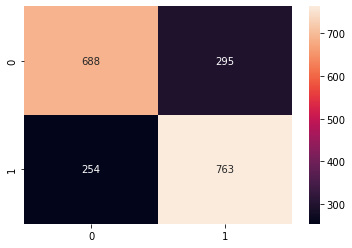

In [328]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt='g');

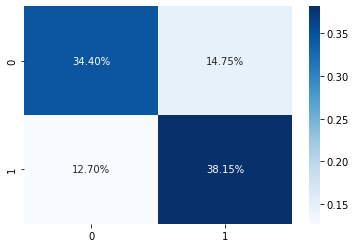

In [329]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues');

In [332]:
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
printCustomMetrics(y_test,y_pred)

Accuracy: 0.73
Precision: 0.72
Recall: 0.75
f1: 0.74


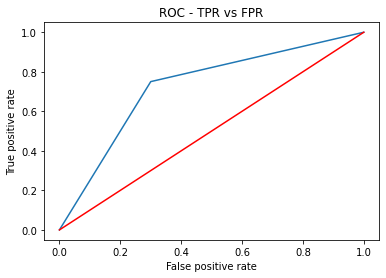

In [331]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds=roc_curve(y_test,y_pred)    
plot_roc_curve(fpr,tpr)